In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
f = open("./drive/My Drive/final_project/descriptions.pkl", "rb")
descriptions_file = pickle.load(f)
f.close()

In [ ]:
descriptions_file

{'2020-01-01': ['have been investigating whether paying to post will shape the future of the social internet but where can you spend your hard earned bitcoin with lot of help from twitter users street wall read full story',
  'rounding up the best investments in the the most profitable among asset classes are cryptocurrencies the breakthrough technology with its forerunner in bitcoin btc has led decade of astronomical returns for those who believed early on in what this breed of new investments has in store',
  'yahoo finance discusses the use case for cryptocurrency and rocky decade for bitcoin',
  'bitcoin btc traded up against the dollar and now trades at or btc ethereum eth traded higher against the nbsp',
  'jack dorsey square crypto says bitcoin was just warming in the here four reasons why this dramatic prediction holds true',
  'in less than decade bitcoin and ethereum have captured the attention of people around the world born during the time of recession and excessive pessimi

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-14,10437.411133,9675.316406,10038.421875,10311.545898,2.289912e+10,10311.545898
2019-08-15,10524.349609,9855.478516,10319.419922,10374.338867,2.022821e+10,10374.338867
2019-08-16,10452.625000,10086.698242,10358.722656,10231.744141,1.377804e+10,10231.744141
2019-08-17,10487.070312,10119.094727,10233.005859,10345.810547,1.299981e+10,10345.810547
2019-08-18,10916.053711,10313.204102,10350.283203,10916.053711,1.603826e+10,10916.053711
...,...,...,...,...,...,...
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391
2020-08-11,11748.396484,11249.605469,11404.596680,11584.934570,2.506455e+10,11584.934570


In [ ]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,Low_Past_1,High_Past_1,Adj Close_Past_2,Volume_Past_2,Close_Past_2,Open_Past_2,Low_Past_2,High_Past_2,Adj Close_Past_3,Volume_Past_3,Close_Past_3,Open_Past_3,Low_Past_3,High_Past_3,Adj Close_Past_4,Volume_Past_4,Close_Past_4,Open_Past_4,Low_Past_4,High_Past_4,Adj Close_Past_5,Volume_Past_5,Close_Past_5,Open_Past_5,Low_Past_5,High_Past_5,Adj Close_Past_6,Volume_Past_6,Close_Past_6,Open_Past_6,...,Close_Past_24,Open_Past_24,Low_Past_24,High_Past_24,Adj Close_Past_25,Volume_Past_25,Close_Past_25,Open_Past_25,Low_Past_25,High_Past_25,Adj Close_Past_26,Volume_Past_26,Close_Past_26,Open_Past_26,Low_Past_26,High_Past_26,Adj Close_Past_27,Volume_Past_27,Close_Past_27,Open_Past_27,Low_Past_27,High_Past_27,Adj Close_Past_28,Volume_Past_28,Close_Past_28,Open_Past_28,Low_Past_28,High_Past_28,Adj Close_Past_29,Volume_Past_29,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,10226.6,10441.5,10410.1,1.53236e+10,10410.1,10176.8,10099.2,10442.3,10178.4,1.54281e+10,10178.4,10123,9980.78,10215.9,10116,1.49068e+10,10116,10336.4,10020.6,10394.4,10335,1.75959e+10,10335,10443.2,...,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,10313.1,10387,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,10226.6,10441.5,10410.1,1.53236e+10,10410.1,10176.8,10099.2,10442.3,10178.4,1.54281e+10,10178.4,10123,9980.78,10215.9,10116,1.49068e+10,10116,10336.4,...,10408,10136.3,10078.2,10442.4,10131.1,1.70975e+10,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,10276.8,1.51602e+10,10276.8,10347.2,10189.7,10386.9,10347.7,1.20434e+10,10347.7,10356.5,10313.1,10387,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,10226.6,10441.5,10410.1,1.53236e+10,10410.1,10176.8,10099.2,10442.3,10178.4,1.54281e+10,10178.4,10123,...,10160,10407.6,9982.3,10418,10408,1.5627e+10,10408,10136.3,10078.2,10442.4,10131.1,1.70975e+10,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,10241.3,1.53046e+10,10241.3,10281.5,10199.7,10296.8,10276.8,1.51602e+10,10276.8,10347.2,10189.7,10386.9,10347.7,1.20434e+10,10347.7,10356.5,10313.1,10387,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,10226.6,10441.5,10410.1,1.53236e+10,10410.1,10176.8,...,10138.5,10160.7,10008.8,10304.6,10160,1.5451e+10,10160,10407.6,9982.3,10418,10408,1.5627e+10,10408,10136.3,10078.2,10442.4,10131.1,1.70975e+10,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1
2019-09-18,10295.668945,9851.692383,1020

In [ ]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN,NEUTRAL
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,Low_Past_1,High_Past_1,Adj Close_Past_2,Volume_Past_2,Close_Past_2,Open_Past_2,Low_Past_2,High_Past_2,Adj Close_Past_3,Volume_Past_3,Close_Past_3,Open_Past_3,Low_Past_3,High_Past_3,Adj Close_Past_4,Volume_Past_4,Close_Past_4,Open_Past_4,Low_Past_4,High_Past_4,Adj Close_Past_5,Volume_Past_5,Close_Past_5,Open_Past_5,Low_Past_5,High_Past_5,Adj Close_Past_6,Volume_Past_6,Close_Past_6,Open_Past_6,...,Open_Past_24,Low_Past_24,High_Past_24,Adj Close_Past_25,Volume_Past_25,Close_Past_25,Open_Past_25,Low_Past_25,High_Past_25,Adj Close_Past_26,Volume_Past_26,Close_Past_26,Open_Past_26,Low_Past_26,High_Past_26,Adj Close_Past_27,Volume_Past_27,Close_Past_27,Open_Past_27,Low_Past_27,High_Past_27,Adj Close_Past_28,Volume_Past_28,Close_Past_28,Open_Past_28,Low_Past_28,High_Past_28,Adj Close_Past_29,Volume_Past_29,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,10313.1,10387,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,10226.6,10441.5,10410.1,1.53236e+10,10410.1,10176.8,10099.2,10442.3,10178.4,1.54281e+10,10178.4,10123,9980.78,10215.9,10116,1.49068e+10,10116,10336.4,...,10136.3,10078.2,10442.4,10131.1,1.70975e+10,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,DOWN
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,10276.8,1.51602e+10,10276.8,10347.2,10189.7,10386.9,10347.7,1.20434e+10,10347.7,10356.5,10313.1,10387,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,10226.6,10441.5,10410.1,1.53236e+10,10410.1,10176.8,10099.2,10442.3,10178.4,1.54281e+10,10178.4,10123,...,10407.6,9982.3,10418,10408,1.5627e+10,10408,10136.3,10078.2,10442.4,10131.1,1.70975e+10,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,DOWN
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,10241.3,1.53046e+10,10241.3,10281.5,10199.7,10296.8,10276.8,1.51602e+10,10276.8,10347.2,10189.7,10386.9,10347.7,1.20434e+10,10347.7,10356.5,10313.1,10387,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,10226.6,10441.5,10410.1,1.53236e+10,10410.1,10176.8,...,10160.7,10008.8,10304.6,10160,1.5451e+10,10160,10407.6,9982.3,10418,10408,1.5627e+10,10408,10136.3,10078.2,10442.4,10131.1,1.70975e+10,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,DOWN
2019-09-18,10295.668945,9851.692383,10200.496094,10266.415039,1.993769e+10,10266.415039,10198.2,1.61693e+10,10198.2,10247.8,10191.5,10275.9,10241.3,1.53046e+10,10241.3,10281.5,10199.7,10296.8,10276.8,1.51602e+10,10276.8,10347.2,10189.7,10386.9,10347.7,1.20434e+10,10347.7,10356.5,10313.1,10387,10358,1.34687e+10,10358,10345.4,10291.7,10422.1,10360.5,1.41099e+10,10360.5,10415.4,...,10126.3,10126.3,10512.3,10138.5,1.41539e+10,10138.5,10160.7,10008.8,10304.6,10160,1.5451e+10,10160,10407.6,9982.3,10418,10408,1.5627e+10,10408,10136.3,10078.2,10442.4,10131.1,1.70975e+10,10131.1,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,DOWN
2019-09-19,10285.872070,10132.186523,10266.318359,1018

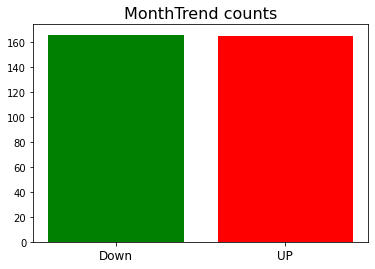

In [ ]:
MonthTrend_count = btc_df['MonthTrend'].value_counts()
plt.bar(MonthTrend_count.index, MonthTrend_count.values, color=['green', 'red']);
plt.xticks([0, 1], ['Down', 'UP'], fontsize=12)
plt.title('MonthTrend counts', fontsize=16);

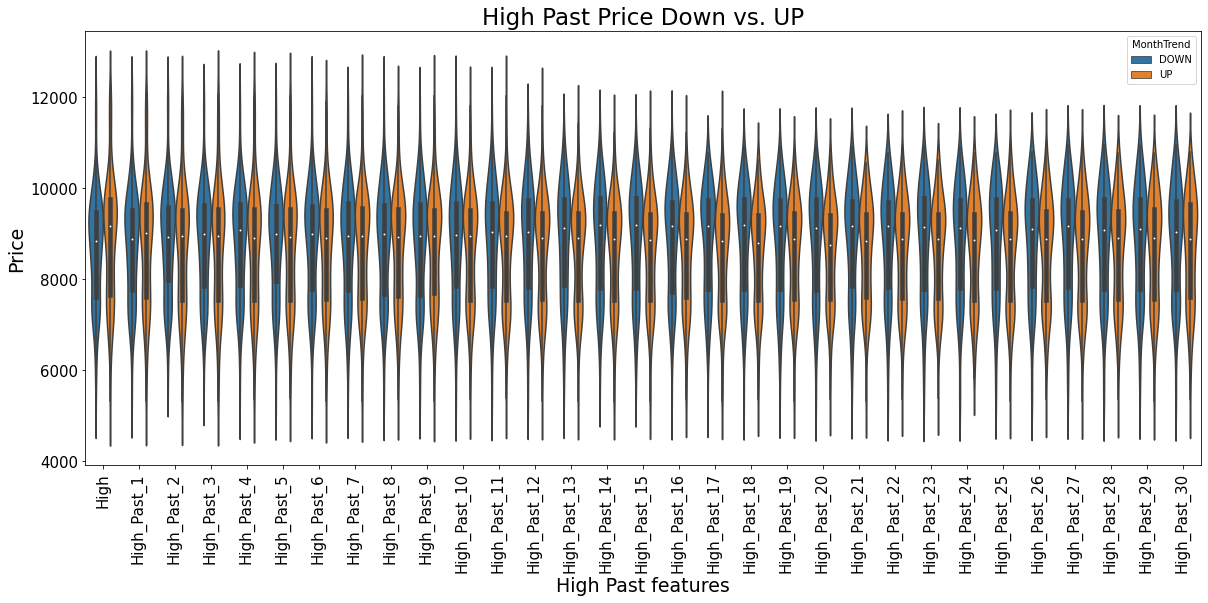

In [ ]:
## select High_Past columns
High_Past_list = ['High']
for i in range(30):
    High_Past_list.append('High_Past_' + str(i+1))
High_Past_df = btc_df[High_Past_list]

## melt the dataframe so that multi-column violinplot can be plotted
High_Past_melt = High_Past_df.melt(var_name='High_Past', value_name='Price')
High_Past_melt['MonthTrend'] = ""
for i in range(31):
  High_Past_melt['MonthTrend'].iloc[i*331: (i+1)*331] = btc_df['MonthTrend'].values
High_Past_melt['Price'] = High_Past_melt['Price'].astype('float') ## transform Price to float type

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
ax = sns.violinplot(x='High_Past', y='Price', hue='MonthTrend', data=High_Past_melt);
ax.set_xticklabels(High_Past_list, rotation=90, fontsize=15);
ax.set_yticklabels([2000, 4000, 6000, 8000, 10000, 12000], fontsize=15)
ax.set_xlabel('High Past features', fontsize=19);
ax.set_ylabel('Price', fontsize=19);
ax.set_title('High Past Price Down vs. UP', fontsize=23);

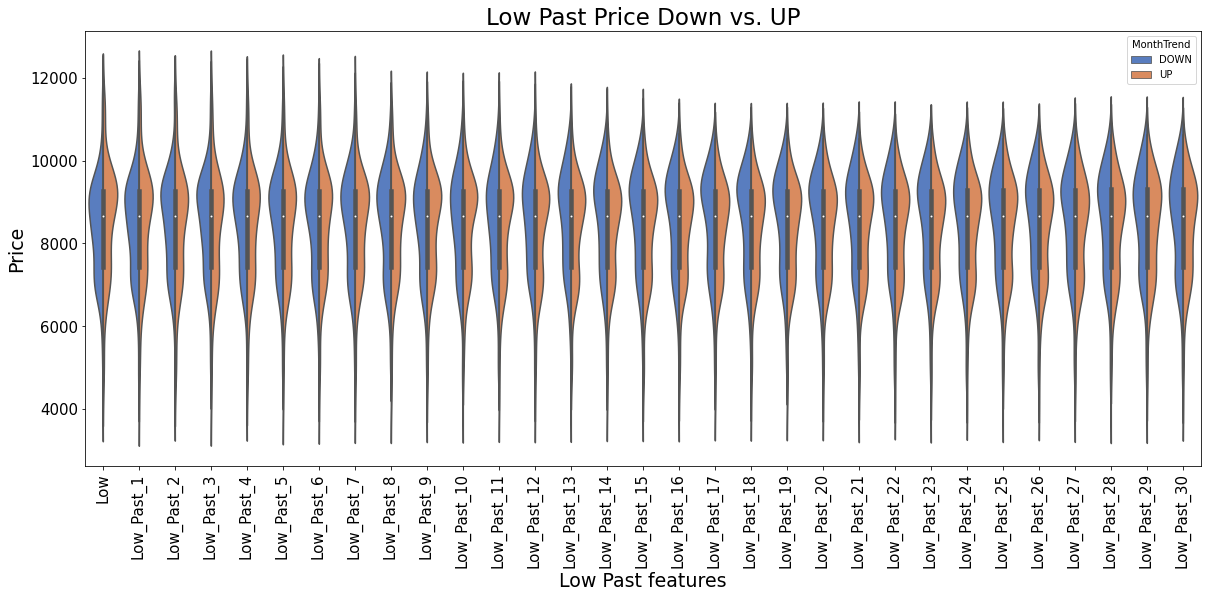

In [ ]:
## select High_Past columns
Low_Past_list = ['Low']
for i in range(30):
    Low_Past_list.append('Low_Past_' + str(i+1))
Low_Past_df = btc_df[Low_Past_list]

## melt the dataframe so that multi-column violinplot can be plotted
Low_Past_melt = Low_Past_df.melt(var_name='Low_Past', value_name='Price')
Low_Past_melt['MonthTrend'] = ""
for i in range(31):
  Low_Past_melt['MonthTrend'].iloc[i*331: (i+1)*331] = btc_df['MonthTrend'].values
Low_Past_melt['Price'] = Low_Past_melt['Price'].astype('float') ## transform Price to float type

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
ax = sns.violinplot(x='Low_Past', y='Price', hue='MonthTrend', palette='muted', split=True, data=Low_Past_melt);
ax.set_xticklabels(Low_Past_list, rotation=90, fontsize=15);
ax.set_yticklabels([2000, 4000, 6000, 8000, 10000, 12000], fontsize=15);
ax.set_xlabel('Low Past features', fontsize=19);
ax.set_ylabel('Price', fontsize=19);
ax.set_title('Low Past Price Down vs. UP', fontsize=23);

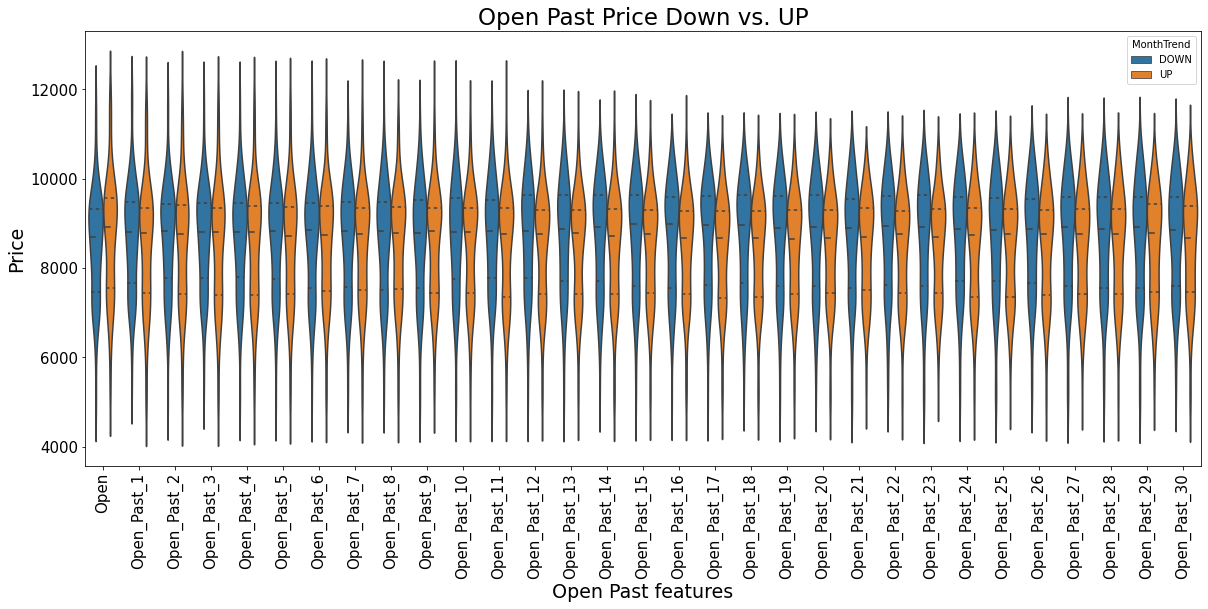

In [ ]:
## select Open_Past columns
Open_Past_list = ['Open']
for i in range(30):
    Open_Past_list.append('Open_Past_' + str(i+1))
Open_Past_df = btc_df[Open_Past_list]

## melt the dataframe so that multi-column violinplot can be plotted
Open_Past_melt = Open_Past_df.melt(var_name='Open_Past', value_name='Price')
Open_Past_melt['MonthTrend'] = ""
for i in range(31):
  Open_Past_melt['MonthTrend'].iloc[i*331: (i+1)*331] = btc_df['MonthTrend'].values
Open_Past_melt['Price'] = Open_Past_melt['Price'].astype('float') ## transform Price to float type

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
ax = sns.violinplot(x='Open_Past', y='Price', hue='MonthTrend', inner='quartile', data=Open_Past_melt);
ax.set_xticklabels(Open_Past_list, rotation=90, fontsize=15);
ax.set_yticklabels([2000, 4000, 6000, 8000, 10000, 12000], fontsize=15);
ax.set_xlabel('Open Past features', fontsize=19);
ax.set_ylabel('Price', fontsize=19);
ax.set_title('Open Past Price Down vs. UP', fontsize=23);

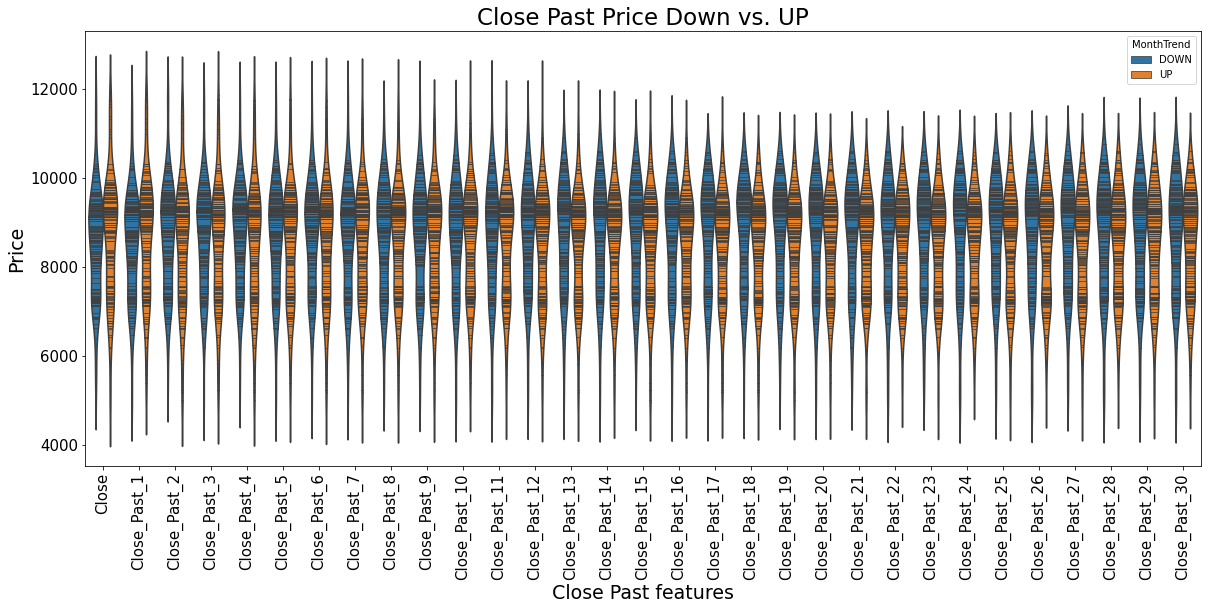

In [ ]:
## select Close_Past columns
Close_Past_list = ['Close']
for i in range(30):
    Close_Past_list.append('Close_Past_' + str(i+1))
Close_Past_df = btc_df[Close_Past_list]

## melt the dataframe so that multi-column violinplot can be plotted
Close_Past_melt = Close_Past_df.melt(var_name='Close_Past', value_name='Price')
Close_Past_melt['MonthTrend'] = ""
for i in range(31):
  Close_Past_melt['MonthTrend'].iloc[i*331: (i+1)*331] = btc_df['MonthTrend'].values
Close_Past_melt['Price'] = Close_Past_melt['Price'].astype('float') ## transform Price to float type

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
ax = sns.violinplot(x='Close_Past', y='Price', hue='MonthTrend', inner='stick', data=Close_Past_melt);
ax.set_xticklabels(Close_Past_list, rotation=90, fontsize=15);
ax.set_yticklabels([2000, 4000, 6000, 8000, 10000, 12000], fontsize=15);
ax.set_xlabel('Close Past features', fontsize=19);
ax.set_ylabel('Price', fontsize=19);
ax.set_title('Close Past Price Down vs. UP', fontsize=23);

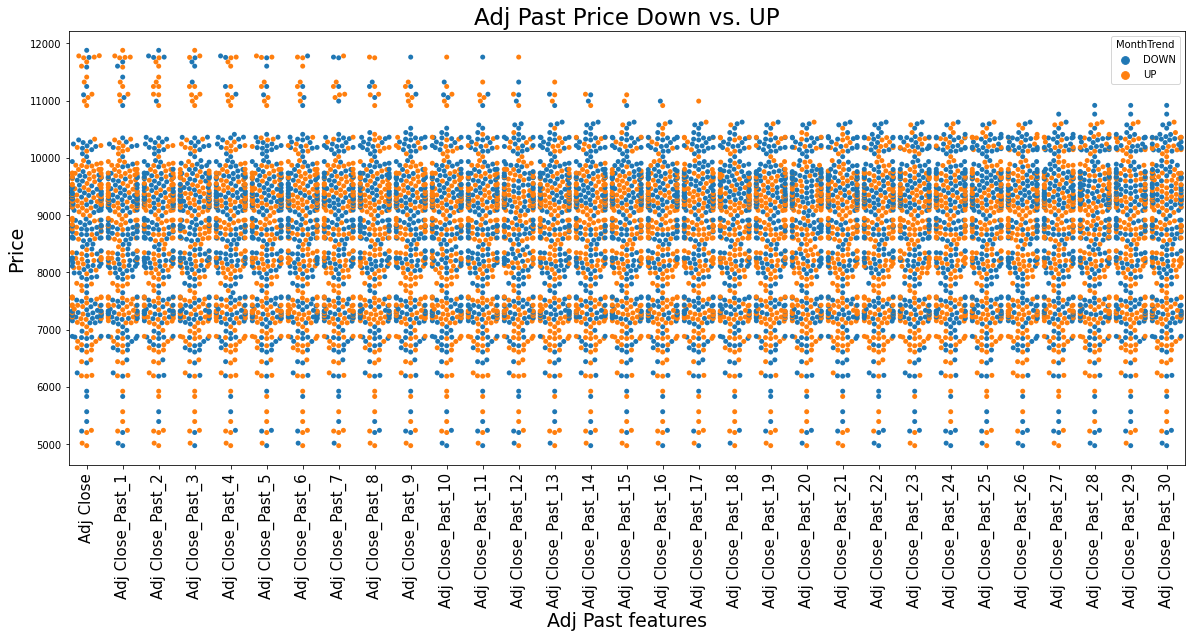

In [ ]:
## select Adj Close_Past columns
Adj_Past_list = ['Adj Close']
for i in range(30):
    Adj_Past_list.append('Adj Close_Past_' + str(i+1))
Adj_Past_df = btc_df[Adj_Past_list]

## melt the dataframe so that multi-column violinplot can be plotted
Adj_Past_melt = Adj_Past_df.melt(var_name='Adj_Past', value_name='Price')
Adj_Past_melt['MonthTrend'] = ""
for i in range(31):
  Adj_Past_melt['MonthTrend'].iloc[i*331: (i+1)*331] = btc_df['MonthTrend'].values
Adj_Past_melt['Price'] = Adj_Past_melt['Price'].astype('float') ## transform Price to float type

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
ax = sns.swarmplot(x='Adj_Past', y='Price', hue='MonthTrend', data=Adj_Past_melt);
ax.set_xticklabels(Adj_Past_list, rotation=90, fontsize=15);
ax.set_yticklabels([4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]);
ax.set_xlabel('Adj Past features', fontsize=19);
ax.set_ylabel('Price', fontsize=19);
ax.set_title('Adj Past Price Down vs. UP', fontsize=23);

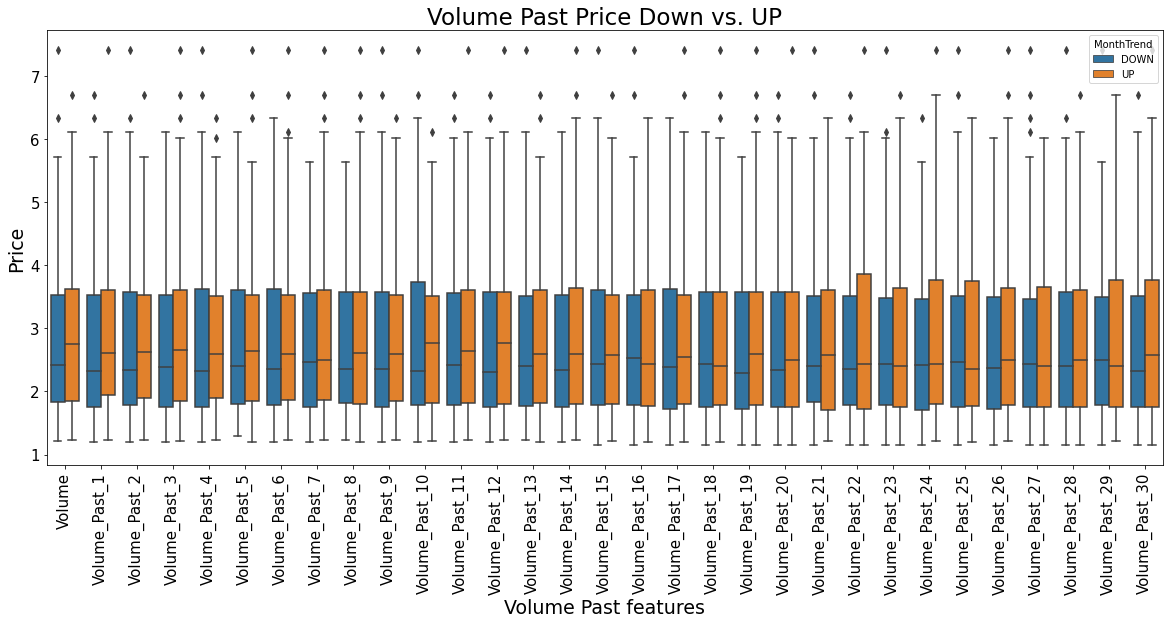

In [ ]:
## select Close_Past columns
Volume_Past_list = ['Volume']
for i in range(30):
    Volume_Past_list.append('Volume_Past_' + str(i+1))
Volume_Past_df = btc_df[Volume_Past_list]

## melt the dataframe so that multi-column violinplot can be plotted
Volume_Past_melt = Volume_Past_df.melt(var_name='Volume_Past', value_name='Price')
Volume_Past_melt['MonthTrend'] = ""
for i in range(31):
  Volume_Past_melt['MonthTrend'].iloc[i*331: (i+1)*331] = btc_df['MonthTrend'].values
Volume_Past_melt['Price'] = Volume_Past_melt['Price'].astype('float') ## transform Price to float type

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
ax = sns.boxplot(x='Volume_Past', y='Price', hue='MonthTrend', data=Volume_Past_melt);
ax.set_xticklabels(Volume_Past_list, rotation=90, fontsize=15);
ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=15)
ax.set_xlabel('Volume Past features', fontsize=19);
ax.set_ylabel('Price', fontsize=19);
ax.set_title('Volume Past Price Down vs. UP', fontsize=23);

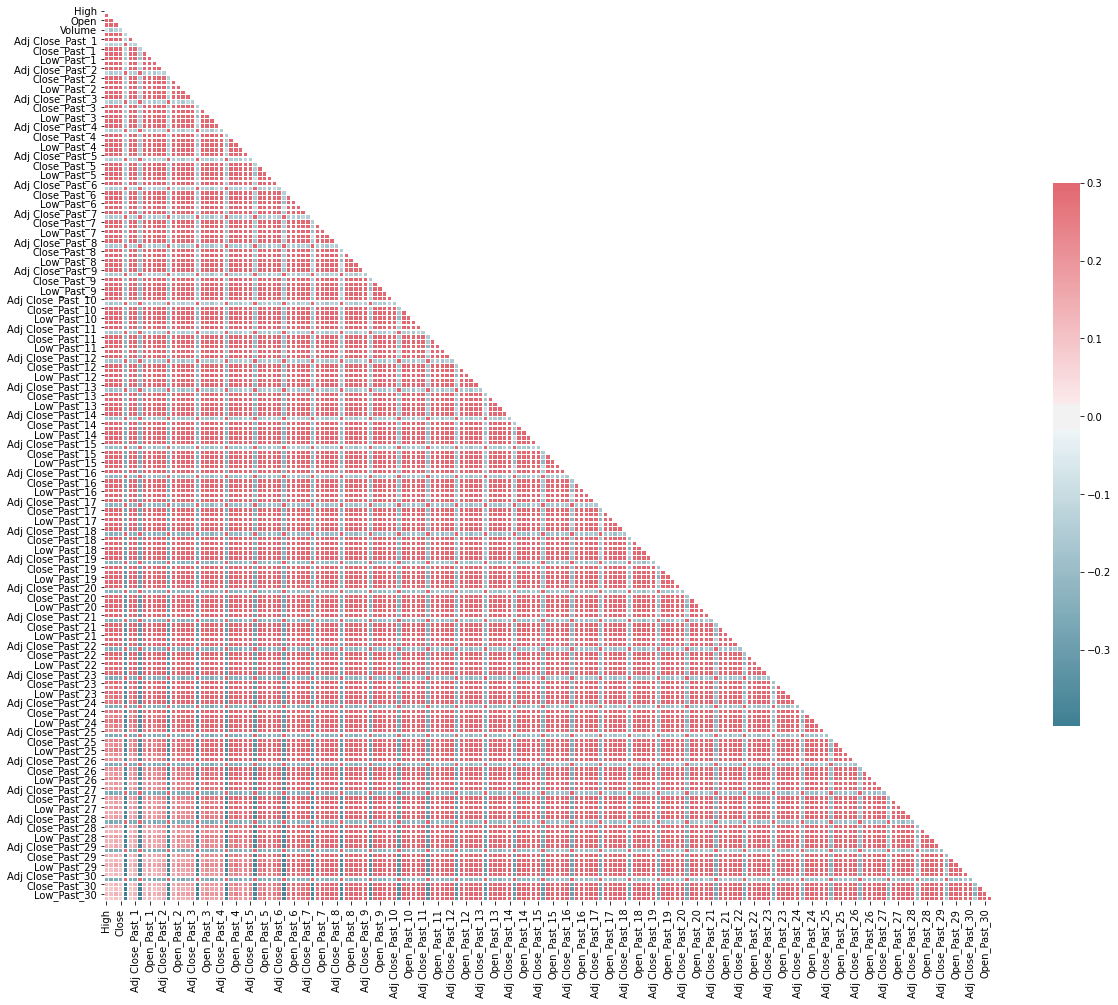

In [ ]:
btc_features = btc_df.drop(columns=['MonthTrend'])
btc_features = btc_features.astype('float')

corr = btc_features.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(20, 20));
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
## select Close_Past columns
Close_Past_list = ['Close']
for i in range(30):
    Close_Past_list.append('Close_Past_' + str(i+1))
Close_Past_df = btc_df[Close_Past_list]

## melt the dataframe so that multi-column violinplot can be plotted
Close_Past_melt = Close_Past_df.melt(var_name='Close_Past', value_name='Price')
Close_Past_melt['MonthTrend'] = ""
for i in range(31):
  Close_Past_melt['MonthTrend'].iloc[i*331: (i+1)*331] = btc_df['MonthTrend'].values
Close_Past_melt['Price'] = Close_Past_melt['Price'].astype('float') ## transform Price to float type

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
ax = sns.violinplot(x='Close_Past', y='Price', hue='MonthTrend', data=Close_Past_melt);
ax.set_xticklabels(Close_Past_list, rotation=90);
ax.set_xlabel('Close Past features', fontsize=12);
ax.set_ylabel('Price', fontsize=12);
ax.set_title('Close Past Price Down vs. UP', fontsize=15);

In [ ]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,Close_Past_10,Close_Past_11,Close_Past_12,Close_Past_13,Close_Past_14,Close_Past_15,Close_Past_16,Close_Past_17,Close_Past_18,Close_Past_19,Close_Past_20,Close_Past_21,Close_Past_22,Close_Past_23,Close_Past_24,Close_Past_25,Close_Past_26,Close_Past_27,Close_Past_28,Close_Past_29,Close_Past_30,Open,Open_Past_1,Open_Past_2,Open_Past_3,Open_Past_4,Open_Past_5,Open_Past_6,Open_Past_7,Open_Past_8,Open_Past_9,Open_Past_10,Open_Past_11,Open_Past_12,Open_Past_13,Open_Past_14,Open_Past_15,Open_Past_16,Open_Past_17,Open_Past_18,Open_Past_19,Open_Past_20,Open_Past_21,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10347.222656,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10281.513672,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN
2019-09-17,10198.248047,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10247.795898,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,DOWN
2019-09-18,10266.415039,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10200.496094,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,DOWN
2019-09-19,10181.641602,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10266.318359,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-08,11675.739258,11754,11601.5,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,9536.89,9581.07,9525.36,9374.89,9164.23,9185.82,9159.04,9151.39,9132.23,9192.84,9243.21,9243.61,9276.5,9240.35,9278.81,11737.325195,11604.6,11778.9,11749.9,11203.8,11043.8,11043.8,11758.8,1132

In [ ]:
btc_selected = btc.iloc[:327]
btc_selected

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,Close_Past_10,Close_Past_11,Close_Past_12,Close_Past_13,Close_Past_14,Close_Past_15,Close_Past_16,Close_Past_17,Close_Past_18,Close_Past_19,Close_Past_20,Close_Past_21,Close_Past_22,Close_Past_23,Close_Past_24,Close_Past_25,Close_Past_26,Close_Past_27,Close_Past_28,Close_Past_29,Close_Past_30,Open,Open_Past_1,Open_Past_2,Open_Past_3,Open_Past_4,Open_Past_5,Open_Past_6,Open_Past_7,Open_Past_8,Open_Past_9,Open_Past_10,Open_Past_11,Open_Past_12,Open_Past_13,Open_Past_14,Open_Past_15,Open_Past_16,Open_Past_17,Open_Past_18,Open_Past_19,Open_Past_20,Open_Past_21,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10347.222656,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10281.513672,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN
2019-09-17,10198.248047,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10247.795898,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,DOWN
2019-09-18,10266.415039,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10200.496094,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,DOWN
2019-09-19,10181.641602,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10266.318359,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,9536.89,9581.07,9525.36,9374.89,9164.23,9185.82,9159.04,9151.39,9132.23,9192.84,9243.21,9243.61,9276.5,9240.35,9278.81,9277.97,9428.33,9252.28,9375.47,11203.823242,11043.8,11043.8,11758.8,11322.6,11110.2,11099.8,10913,11

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sid.polarity_scores('fraud')

{'compound': -0.5859, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}

In [ ]:
Stopwords = set(stopwords.words('english'))
sentence = 'Bitcoin price has risen 20% giving analyzers confidence to expect a considerable trading volume'
text = ''
for word in sentence.split():
    if word not in Stopwords:
      text = text + ' ' + word
text

' Bitcoin price risen 20% giving analyzers confidence expect considerable trading volume'

In [ ]:
# load pre-fetched news sentiment data and add in the dataframe
import pickle
import warnings
import os
warnings.filterwarnings('ignore')
#f = open(os.path.join(os.getcwd(), "polaritys_score.pkl"), "rb")
f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")
polaritys_file = pickle.load(f)
f.close()

polaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=['neg', 'neu', 'pos'])
for date in list(polaritys_file.keys())[::-1]:
  for polar in ['neg', 'neu', 'pos']:
    polaritys_df.loc[date][polar] = polaritys_file[date][polar]

## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)
btc_index_str = [btc_index.strftime('%Y-%m-%d') for btc_index in list(btc_selected.index)]

sentiment_data = polaritys_df.loc[btc_index_str]
sentiment_data.columns = ['negative', 'neutral', 'positive']

## add sentiment in the dataframe
btc_selected[['negative', 'neutral', 'positive']] = sentiment_data[['negative', 'neutral', 'positive']]
btc_selected = btc_selected.dropna()
btc_selected

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,Close_Past_10,Close_Past_11,Close_Past_12,Close_Past_13,Close_Past_14,Close_Past_15,Close_Past_16,Close_Past_17,Close_Past_18,Close_Past_19,Close_Past_20,Close_Past_21,Close_Past_22,Close_Past_23,Close_Past_24,Close_Past_25,Close_Past_26,Close_Past_27,Close_Past_28,Close_Past_29,Close_Past_30,Open,Open_Past_1,Open_Past_2,Open_Past_3,Open_Past_4,Open_Past_5,Open_Past_6,Open_Past_7,Open_Past_8,Open_Past_9,Open_Past_10,Open_Past_11,Open_Past_12,Open_Past_13,Open_Past_14,Open_Past_15,Open_Past_16,Open_Past_17,Open_Past_18,Open_Past_19,Open_Past_20,Open_Past_21,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10347.222656,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN,0.0291676,0.881429,0.089403
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10281.513672,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN,0.0371,0.894067,0.0688333
2019-09-17,10198.248047,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10247.795898,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,DOWN,0.0298333,0.8957,0.0744667
2019-09-18,10266.415039,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10200.496094,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,DOWN,0.042,0.8364,0.1216
2019-09-19,10181.641602,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10266.318359,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,UP,0.0375692,0.856024,0.106407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,9536.89,9581.07,9525.36,9374.89,9164.23,9185.82,91

In [ ]:
btc_selected.to_csv('bitcoin_df.csv')

In [ ]:
pd.read_csv('bitcoin_df.csv')

,Date,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,Close_Past_10,Close_Past_11,Close_Past_12,Close_Past_13,Close_Past_14,Close_Past_15,Close_Past_16,Close_Past_17,Close_Past_18,Close_Past_19,Close_Past_20,Close_Past_21,Close_Past_22,Close_Past_23,Close_Past_24,Close_Past_25,Close_Past_26,Close_Past_27,Close_Past_28,Close_Past_29,Close_Past_30,Open,Open_Past_1,Open_Past_2,Open_Past_3,Open_Past_4,Open_Past_5,Open_Past_6,Open_Past_7,Open_Past_8,Open_Past_9,Open_Past_10,Open_Past_11,Open_Past_12,Open_Past_13,Open_Past_14,Open_Past_15,Open_Past_16,Open_Past_17,Open_Past_18,Open_Past_19,Open_Past_20,Open_Past_21,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
0,2019-09-15,10276.793945,10347.712891,10358.048828,10360.546875,10410.126953,10178.372070,10115.975586,10334.974609,10441.276367,10517.254883,10353.302734,10575.533203,10594.493164,10623.540039,10346.760742,9757.970703,9630.664062,9598.173828,9510.200195,9754.422852,10185.500000,10370.820312,10138.517578,10159.960938,10407.964844,10131.055664,10138.049805,10763.232422,10916.053711,10345.810547,10231.744141,10347.222656,10356.465820,10345.403320,10415.362305,10176.819336,10123.035156,10336.408203,10443.228516,10518.114258,10353.931641,10578.198242,10588.183594,10621.180664,10345.725586,9757.473633,9630.592773,9597.539062,9514.844727,9756.786133,10203.426758,10372.826172,10126.299805,10160.737305,10407.644531,10136.309570,10142.521484,10764.572266,10916.346680,10350.283203,10233.005859,10358.722656,DOWN,0.029168,0.881429,0.089403
1,2019-09-16,10241.272461,10276.793945,10347.712891,10358.048828,10360.546875,10410.126953,10178.372070,10115.975586,10334.974609,10441.276367,10517.254883,10353.302734,10575.533203,10594.493164,10623.540039,10346.760742,9757.970703,9630.664062,9598.173828,9510.200195,9754.422852,10185.500000,10370.820312,10138.517578,10159.960938,10407.964844,10131.055664,10138.049805,10763.232422,10916.053711,10345.810547,10281.513672,10347.222656,10356.465820,10345.403320,10415.362305,10176.819336,10123.035156,10336.408203,10443.228516,10518.114258,10353.931641,10578.198242,10588.183594,10621.180664,10345.725586,9757.473633,9630.592773,9597.539062,9514.844727,9756.786133,10203.426758,10372.826172,10126.299805,10160.737305,10407.644531,10136.309570,10142.521484,10764.572266,10916.346680,10350.283203,10233.005859,DOWN,0.037100,0.894067,0.068833
2,2019-09-17,10198.248047,10241.272461,10276.793945,10347.712891,10358.048828,10360.546875,10410.126953,10178.372070,10115.975586,10334.974609,10441.276367,10517.254883,10353.302734,10575.533203,10594.493164,10623.540039,10346.760742,9757.970703,9630.664062,9598.173828,9510.200195,9754.422852,10185.500000,10370.820312,10138.517578,10159.960938,10407.964844,10131.055664,10138.049805,10763.232422,10916.053711,10247.795898,10281.513672,10347.222656,10356.465820,10345.403320,10415.362305,10176.819336,10123.035156,10336.408203,10443.228516,10518.114258,10353.931641,10578.198242,10588.183594,10621.180664,10345.725586,9757.473633,9630.592773,9597.539062,9514.844727,9756.786133,10203.426758,10372.826172,10126.299805,10160.737305,10407.644531,10136.309570,10142.521484,10764.572266,10916.346680,10350.283203,DOWN,0.029833,0.895700,0.074467
3,2019-09-18,10266.415039,10198.248047,10241.272461,10276.793945,10347.712891,10358.048828,10360.546875,10410.126953,10178.372070,10115.975586,10334.974609,10441.276367,10517.254883,10353.302734,10575.533203,10594.493164,10623.540039,10346.760742,9757.970703,9630.664062,9598.173828,9510.200195,9754.422852,10185.500000,10370.820312,10138.517578,10159.960938,10407.964844,10131.055664,10138.049805,10763.232422,10200.496094,10247.795898,10281.513672,10347.222656,10356.465820,10345.403320,10415.362305,10176.819336,10123.035156,10336.408203,10443.228516,10518.114258,10353.931641,10578.198242,10588.183594,10621.180664,10345.725586

In [ ]:
btc_selected[btc_selected['MonthTrend'] == 'UP']

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,Close_Past_10,Close_Past_11,Close_Past_12,Close_Past_13,Close_Past_14,Close_Past_15,Close_Past_16,Close_Past_17,Close_Past_18,Close_Past_19,Close_Past_20,Close_Past_21,Close_Past_22,Close_Past_23,Close_Past_24,Close_Past_25,Close_Past_26,Close_Past_27,Close_Past_28,Close_Past_29,Close_Past_30,Open,Open_Past_1,Open_Past_2,Open_Past_3,Open_Past_4,Open_Past_5,Open_Past_6,Open_Past_7,Open_Past_8,Open_Past_9,Open_Past_10,Open_Past_11,Open_Past_12,Open_Past_13,Open_Past_14,Open_Past_15,Open_Past_16,Open_Past_17,Open_Past_18,Open_Past_19,Open_Past_20,Open_Past_21,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-19,10181.641602,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10266.318359,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,UP,0.0375692,0.856024,0.106407
2019-09-22,9729.324219,10070.4,10019.7,10181.6,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10067.962891,10024.1,10183.6,10266.3,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,UP,0.0361679,0.861862,0.10197
2019-09-27,8245.915039,8251.85,8118.97,8486.99,8620.57,9729.32,10070.4,10019.7,10181.6,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,8251.273438,8113.1,8487.67,8603.43,9729.32,10068,10024.1,10183.6,10266.3,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,UP,0.0530649,0.870438,0.0764975
2019-09-30,8343.276367,8293.87,8104.19,8245.92,8251.85,8118.97,8486.99,8620.57,9729.32,10070.4,10019.7,10181.6,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,8299.720703,8104.23,8246.04,8251.27,8113.1,8487.67,8603.43,9729.32,10068,10024.1,10183.6,10266.3,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,UP,0.0635958,0.838577,0.0978268
2019-10-01,8393.041992,8343.28,8293.87,8104.19,8245.92,8251.85,8118.97,8486.99,8620.57,9729.32,10070.4,10019.7,10181.6,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,8344.212891,8299.72,8104.23,8246.04,8251.27,8113.1,8487.67,8603.43,9729.32,10068,10024.1,10183.6,10266.3,10200.5,10247.8,10281.5,10347.2,10356.5,10345.4,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,UP,0.0354322,0.905503,0.0590647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,11053.614258,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,9536.89,9581.07,9525.36,9374.89,9164.23,9185.82,9159.04,9

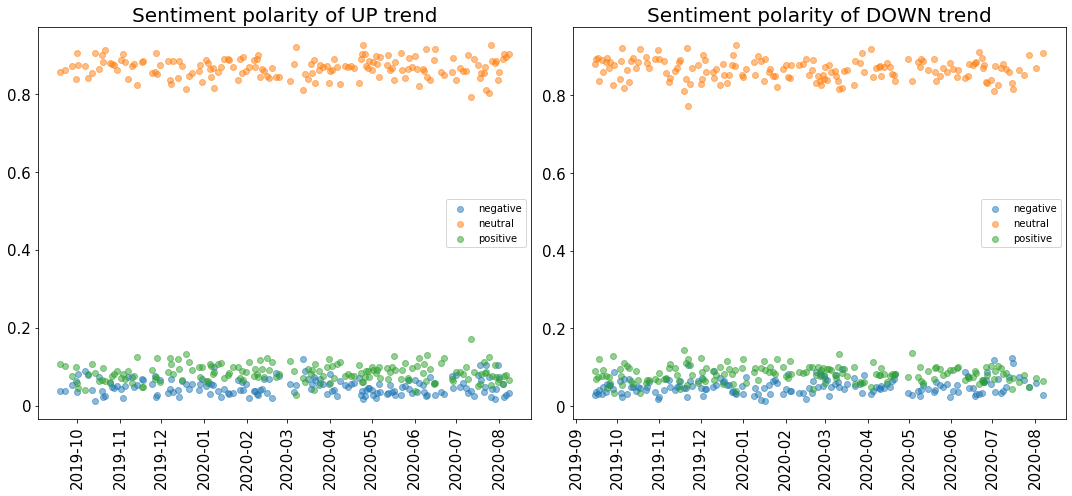

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
ax = plt.subplot(1, 2, 1)
ax.scatter(btc_selected[btc_selected['MonthTrend'] == 'UP'].index, btc_selected[btc_selected['MonthTrend'] == 'UP']['negative'], label='negative', alpha=.5);
ax.scatter(btc_selected[btc_selected['MonthTrend'] == 'UP'].index, btc_selected[btc_selected['MonthTrend'] == 'UP']['neutral'], label='neutral', alpha=.5);
ax.scatter(btc_selected[btc_selected['MonthTrend'] == 'UP'].index, btc_selected[btc_selected['MonthTrend'] == 'UP']['positive'], label='positive', alpha=.5);
ax.legend();
ax.set_xticklabels(['2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08'], fontsize=15, rotation=90)
ax.set_yticklabels([0, 0, 0.2, 0.4, 0.6, 0.8], fontsize=15)
ax.set_title('Sentiment polarity of UP trend', fontsize=20);
ax = plt.subplot(1, 2, 2)
ax.scatter(btc_selected[btc_selected['MonthTrend'] == 'DOWN'].index, btc_selected[btc_selected['MonthTrend'] == 'DOWN']['negative'], label='negative', alpha=.5);
ax.scatter(btc_selected[btc_selected['MonthTrend'] == 'DOWN'].index, btc_selected[btc_selected['MonthTrend'] == 'DOWN']['neutral'], label='neutral', alpha=.5);
ax.scatter(btc_selected[btc_selected['MonthTrend'] == 'DOWN'].index, btc_selected[btc_selected['MonthTrend'] == 'DOWN']['positive'], label='positive', alpha=.5);
ax.legend();
ax.set_xticklabels(['2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08'], fontsize=15, rotation=90)
ax.set_yticklabels([0, 0, 0.2, 0.4, 0.6, 0.8], fontsize=15)
ax.set_title('Sentiment polarity of DOWN trend', fontsize=20);
plt.tight_layout()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
Y = btc['MonthTrend']
le =LabelEncoder()
Y = le.fit_transform(Y)
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
# Create training and testing datasets that are appropriate for time series data
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)
train_size_perc = 0.7
n_time, n_features = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[(train_size+LOOK_AHEAD_DAYS):], Y[(train_size+LOOK_AHEAD_DAYS):]

In [ ]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
model_tree = grid.best_estimator_
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    3.5s finished


0.5567010309278351

In [ ]:
model_tree.score(X_train, Y_train)

0.8391304347826087

In [ ]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(confusion_matrix(Y_test, prediction))

[[32 11]
 [43 11]]


In [ ]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.43      0.74      0.54        43
           1       0.50      0.20      0.29        54

    accuracy                           0.44        97
   macro avg       0.46      0.47      0.42        97
weighted avg       0.47      0.44      0.40        97



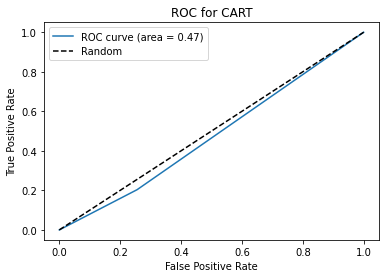

In [ ]:
# Plot the ROC curve

def plot_roc(Y_test,Y_pred, name):
    fpr, tpr, _ = roc_curve(Y_test,Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC for " + name)
    plt.legend(loc="best")
    plt.show()
plot_roc(Y_test,prediction, 'CART')

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
model_random = random_grid.best_estimator_
tree_error_rate =1 - model_random.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 736 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 6436 tasks      | elapsed:   11.8s
[Parallel(n_jobs=6)]: Done 7680 out of 7680 | elapsed:   14.1s finished


0.48453608247422686

In [ ]:
model_random.score(X_train, Y_train)

0.9434782608695652

In [ ]:
new_prediction = model_random.predict(X_test)
print(confusion_matrix(Y_test, new_prediction))

[[27 16]
 [31 23]]


In [ ]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

           0       0.47      0.63      0.53        43
           1       0.59      0.43      0.49        54

    accuracy                           0.52        97
   macro avg       0.53      0.53      0.51        97
weighted avg       0.53      0.52      0.51        97



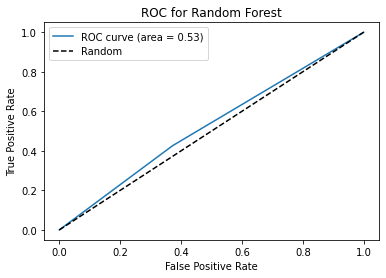

In [ ]:
plot_roc(Y_test,new_prediction, "Random Forest")

In [ ]:
# linear svm
from sklearn.svm import LinearSVC
model_svm = LinearSVC(random_state=42)
param_grid = {
             'C': [1,2,4,6,8,10],
             'loss':["hinge","squared_hinge"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None]}  
svm_grid =  GridSearchCV(model_svm,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
svm_grid.fit(X_train,Y_train)
model_svm = svm_grid.best_estimator_
svm_error_rate =1 - model_svm.score(X_test,Y_test)
svm_error_rate

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:    1.2s finished


0.09278350515463918

In [ ]:
model_svm.score(X_train, Y_train)

0.9956521739130435

In [ ]:
svm_prediction = model_svm.predict(X_test)
print(confusion_matrix(Y_test, svm_prediction))

[[41  2]
 [ 7 47]]


In [ ]:
print(classification_report(Y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        43
           1       0.96      0.87      0.91        54

    accuracy                           0.91        97
   macro avg       0.91      0.91      0.91        97
weighted avg       0.91      0.91      0.91        97



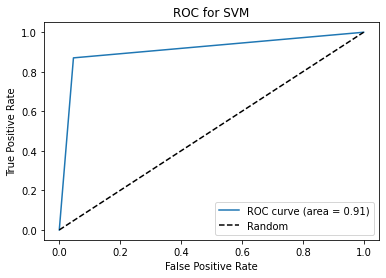

In [ ]:
plot_roc(Y_test,svm_prediction, "SVM")

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model_regression = LogisticRegression()
param_grid = {
             'C': [1,2,4,6,8,10],
             'penalty':["l1", "l2"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None],
              'warm_start':[True,False]}  
regression_grid =  GridSearchCV(model_regression,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
regression_grid.fit(X_train,Y_train)
model_regresssion= regression_grid.best_estimator_
regression_error_rate =1 - model_regresssion.score(X_test,Y_test)
regression_error_rate

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 960 out of 960 | elapsed:    4.7s finished


0.04123711340206182

In [ ]:
regression_prediction = model_regresssion.predict(X_test)
print(confusion_matrix(Y_test, regression_prediction))

[[43  0]
 [ 4 50]]


In [ ]:
print(classification_report(Y_test, regression_prediction))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        43
           1       1.00      0.93      0.96        54

    accuracy                           0.96        97
   macro avg       0.96      0.96      0.96        97
weighted avg       0.96      0.96      0.96        97



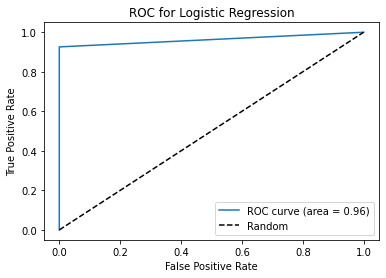

In [ ]:
plot_roc(Y_test,regression_prediction, "Logistic Regression")

In [ ]:
# install tensorflow in virtual enviroment locally or use google colab
# Please read this line at least.Basic model frame tuning may needed. I reached 0.7347 test accuracy for old dataset.
import tensorflow as tf
# Nerual network layer by layer. The input shape(...,62) may vary if new added
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(units=128,activation="relu",input_dim=X_train.shape[1])) 
# dropout exist for preventing overfitting. 
NN_model.add(tf.keras.layers.Dropout(0.2))
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu"))
NN_model.add(tf.keras.layers.Dropout(0.2)) 
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu")) 
# please do not change this line. sigmoid function is a must for binary classification
NN_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# you can play with this line
NN_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy']) 

In [ ]:
# a basic summary of model
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 107,521
Trainable params: 107,521
Non-trainable params: 0
__________________________________________________

In [ ]:
# I added early stop here.
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
NN_model.fit(x=X_train,y=Y_train,batch_size=30,epochs=50,callbacks=[earlyStopping])

Train on 230 samples
Epoch 1/50
230/230 [==============================] - 1s 6ms/sample - loss: 0.7043 - accuracy: 0.5435
Epoch 2/50
230/230 [==============================] - 0s 792us/sample - loss: 0.6732 - accuracy: 0.5870
Epoch 3/50
230/230 [==============================] - 0s 1ms/sample - loss: 0.6560 - accuracy: 0.6130
Epoch 4/50
230/230 [==============================] - 0s 614us/sample - loss: 0.6537 - accuracy: 0.6261
Epoch 5/50
230/230 [==============================] - 0s 1ms/sample - loss: 0.6267 - accuracy: 0.6652
Epoch 6/50
230/230 [==============================] - 0s 510us/sample - loss: 0.6397 - accuracy: 0.6609
Epoch 7/50
230/230 [==============================] - 0s 871us/sample - loss: 0.6295 - accuracy: 0.6565
Epoch 8/50
230/230 [==============================] - 0s 711us/sample - loss: 0.6186 - accuracy: 0.6391
Epoch 9/50
230/230 [==============================] - 0s 623us/sample - loss: 0.6292 - accuracy: 0.6652
Epoch 10/50
230/230 [============================

In [ ]:
test_loss, test_accuracy = NN_model.evaluate(X_test, Y_test)

97/97 [==============================] - 0s 1ms/sample - loss: 0.6496 - accuracy: 0.6495


In [ ]:
NN_prediction = NN_model.predict_classes(X_test)
print(confusion_matrix(Y_test,NN_prediction))

[[25 18]
 [16 38]]


In [ ]:
print(classification_report(Y_test,NN_prediction))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60        43
           1       0.68      0.70      0.69        54

    accuracy                           0.65        97
   macro avg       0.64      0.64      0.64        97
weighted avg       0.65      0.65      0.65        97



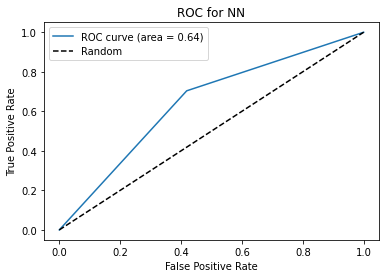

In [ ]:
plot_roc(Y_test,NN_prediction, 'NN')

### Backtesting

In [ ]:
portfolio_value = 100
portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    portfolio_value_history.append(portfolio_value)
    train_df = btc[i: i + LOOK_BACK_DAYS]
    X_TRAIN = train_df.drop(['MonthTrend'], axis=1)
    Y_TRAIN = le.fit_transform(train_df['MonthTrend'])
    test_df = btc[i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS + 1]
    X_TEST = test_df.drop(['MonthTrend'], axis=1)
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    
    model_regression = LogisticRegression()
    param_grid = {'C': [1,2,4]}  #simplified the CV so it runs faster
    regression_grid =  GridSearchCV(model_regression, param_grid, cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
    regression_grid.fit(X_TRAIN,Y_TRAIN)
    model_regresssion= regression_grid.best_estimator_
    
    prediction = model_regresssion.predict(X_TEST)[0]
    if prediction == 1:
        gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
        if gains > 0:
            print("GAIN! " + str(1 + gains))
        elif gains < 0:
            print("LOSS! " + str(1 + gains))
        portfolio_value = portfolio_value * (1 + gains)
    print("portfolio value: " + str(portfolio_value))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9842331661233105
portfolio value: 98.42331661233105
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0018506645601595
portfolio value: 98.60546515627884
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0280415609527733
portfolio value: 101.3705163177352
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0022620313782649
portfolio value: 101.59981960647683
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9799598258266199
portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0666155602568346
portfolio value: 106.19623594857215
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0335444319379241
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9925127480608039
portfolio value: 108.9367386031254
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0021428022555043
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9882157801978252
portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9880809570698097
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0430394464188195
portfolio value: 111.1857238391364
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9902194357285534
portfolio value: 110.09826472106042
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0394438687204568
portfolio value: 114.44096622106802
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 114.44096622106802
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9805426310097526
portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0268936188890219
portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9787225139842252
portfolio value: 112.78024402921604
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9839107086642968
portfolio value: 110.96568982611828
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9917866038777885
portfolio value: 110.05428465960192
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0036575395972402
portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9690812085318505
portfolio value: 107.04162140970024
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9580454394380576
portfolio value: 102.55073722161846
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.55073722161846
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.55073722161846
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0014121515478125
portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9956677812083113
portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.014349607801453
portfolio value: 103.7179115870294
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9828472843381522
portfolio value: 101.93886774053642
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.986175791690628
portfolio value: 100.52964359806973
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.52964359806973
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9698605332244129
portfolio value: 97.4997337448841
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 97.4997337448841
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 97.4997337448841
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0001168245467282
portfolio value: 97.51112410708497
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 97.51112410708497
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 97.51112410708497
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9899444496425026
portfolio value: 96.53059608821
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9748555841151165
portfolio value: 94.10339063455234
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 94.10339063455234
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9847279582693808
portfolio value: 92.6662397257887
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0198216400074884
portfolio value: 94.5030365704809
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9944348100446602
portfolio value: 93.97710922060975
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0843676681862628
portfolio value: 101.90573878843833
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9979226862622207
portfolio value: 101.69404859729455
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9899352624966742
portfolio value: 100.67052469251233
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.67052469251233
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0017470941473823
portfolio value: 100.84640557701653
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9736955059174054
portfolio value: 98.19369189826496
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 98.19369189826496
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 98.19369189826496
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9927569266809558
portfolio value: 97.48246778837819
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9684200200112814
portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.050049279975456
portfolio value: 99.12882430218121
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 99.12882430218121
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0207144931952605
portfolio value: 101.18222765864293
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.18222765864293
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.004977081019406
portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0071910763540914
portfolio value: 102.41705029775879
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0073571235400032
portfolio value: 103.17054518940212
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.025626723407693
portfolio value: 105.81446821479182
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9744009967627031
portfolio value: 103.10572330040851
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0357496552119791
portfolio value: 106.79171735877985
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.79171735877985
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9893857546196765
portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0465127340076705
portfolio value: 110.57265579830195
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.57265579830195
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9978347798052194
portfolio value: 110.33324165097694
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.33324165097694
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9974684008769168
portfolio value: 110.05392211316641
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.027029769268814
portfolio value: 113.02865423501332
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 113.02865423501332
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.967920692457632
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0048728575626913
portfolio value: 109.93587740583942
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9767972207968315
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0367709261874887
portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.180305294438141
portfolio value: 131.40776454503157
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0011506637707783
portfolio value: 131.5589706988925
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9965431396348158
portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9914443935942692
portfolio value: 129.98251386212027
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 129.98251386212027
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 129.98251386212027
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9652000583468278
portfolio value: 125.45912996378583
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9481906825551857
portfolio value: 118.95917807314183
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0012499732343842
portfolio value: 119.10787386171761
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 119.10787386171761
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0282812878999854
portfolio value: 122.47639793355599
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9905832655942777
portfolio value: 121.32307022324613
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0191655082300208
portfolio value: 123.64828852410115
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9895944900688941
portfolio value: 122.36166502989937
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0712622121567903
portfolio value: 131.08142796311816
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 131.08142796311816
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0215641903665413
portfolio value: 133.9080928292329
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9951107770714369
portfolio value: 133.25338631145206
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 133.25338631145206
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9987830368591373
portfolio value: 133.0912218519159
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.016480432667871
portfolio value: 135.28462277233106
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 135.28462277233106
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9998752055024313
portfolio value: 135.26773999580342
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 135.26773999580342
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0717345666984077
portfolio value: 144.97111271267525
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 144.97111271267525
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0233173629517578
portfolio value: 148.3514567653169
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9901531024549559
portfolio value: 146.89065516989078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9575733401219685
portfolio value: 140.6585753037366
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 140.6585753037366
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 140.6585753037366
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.043309254009497
portfolio value: 146.7503932701801
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0157003479230886
portfolio value: 149.054425502372
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0025764080564745
portfolio value: 149.43845052508948
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0144948494370194
portfolio value: 151.60453836555212
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 151.60453836555212
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 151.60453836555212
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.1273680433386057
portfolio value: 170.91411177842508
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9841871527151077
portfolio value: 168.21147303003983
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0221364228899927
portfolio value: 171.93507333198139
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0134782146716854
portfolio value: 174.2524511599418
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9904108184812606
portfolio value: 172.58151277568385
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 172.58151277568385
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 172.58151277568385
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0290116028197172
portfolio value: 177.58837907835792
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.074458089739114
portfolio value: 190.8112705443981
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9905903212205259
portfolio value: 189.015797781072
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9748996932447151
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.000203001592388
portfolio value: 184.3088506715887
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9791937471589017
portfolio value: 180.4740741236634
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9536920566169427
portfolio value: 172.1166909170351
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 172.1166909170351
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 172.1166909170351
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9542008175650334
portfolio value: 164.23388718962306
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0137520681953733
portfolio value: 166.492442806246
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9916344930451488
portfolio value: 165.09964911802018
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0388844527828014
portfolio value: 171.5194586286069
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0371048114569272
portfolio value: 177.8836558022156
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9906351683031609
portfolio value: 176.2178053040094
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0277044581896255
portfolio value: 181.0998241233219
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 181.0998241233219
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0743546514339681
portfolio value: 194.56543842076442
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9376983602682263
portfolio value: 182.44369257201936
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0128970124775534
portfolio value: 184.79667115157162
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.79667115157162
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9862571784482186
portfolio value: 182.25704347657233
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9988386217772866
portfolio value: 182.0453741153425
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0109654591577366
portfolio value: 184.04158523005916
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0011706666946827
portfolio value: 184.2570365843246
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2570365843246
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2570365843246
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9444485780096092
portfolio value: 174.0212961903299
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.017182559759993
portfolio value: 177.0114275116317
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 177.0114275116317
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9904230956881571
portfolio value: 175.31620600825008
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0068897027457264
portfolio value: 176.52408255415546
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0088592606946538
portfolio value: 178.08795542038732
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 178.08795542038732
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 178.08795542038732
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9870062092283622
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9866452943655268
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0333550111628982
portfolio value: 179.21115199733484
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 179.21115199733484
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0189465158811635
portfolio value: 182.60657893473393
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.60657893473393
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0005877262208878
portfolio value: 182.7139016092805
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.7139016092805
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0038356349679378
portfolio value: 183.4147254394214
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9963792090365983
portfolio value: 182.75061905899554
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.000488244088642
portfolio value: 182.83984596844675
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.83984596844675
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9934994498856212
portfolio value: 181.65128638682356
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 181.65128638682356
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0008585168499806
portfolio value: 181.8072370770073
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.003036853640908
portfolio value: 182.35935904686804
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 182.35935904686804
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.35935904686804
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0160300714098067
portfolio value: 185.2825925946359
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0056607392141264
portfolio value: 186.33142903223134
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 186.33142903223134
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.014427186018474
portfolio value: 189.0196672199674
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 189.0196672199674
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.1096043820812165
portfolio value: 209.73705104680909
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 209.73705104680909
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0171827594501375
portfolio value: 213.34091234272762
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0010253180716313
portfolio value: 213.55965463557092
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 213.55965463557092
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 213.55965463557092
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9400319326300404
portfolio value: 200.7528948788797
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0183433831596385
portfolio value: 204.4353821500496
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0484833799148676
portfolio value: 214.3471004508716
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0025449082386875
portfolio value: 214.8925941527478
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9849373067625922
portfolio value: 211.65573292803418
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0128822004898905
portfolio value: 214.38232451444784
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9947529836248726
portfolio value: 213.25745694718267


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

base_portfolio_value = 100
base_portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    base_portfolio_value_history.append(base_portfolio_value)
    train_df = btc[i: i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS]
    X_TRAIN = train_df['Open']
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    
    model = ARIMA(list(X_TRAIN), order=(5,1,0))
    
    try:
        model_fit = model.fit(disp=0)
        prediction = model_fit.forecast()[0]
    except:
        continue
    print(prediction)
    if prediction >= train_df.tail(1)['Open'][0]:
        gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
        if gains > 0:
            print("GAIN! " + str(1 + gains))
        elif gains < 0:
            print("LOSS! " + str(1 + gains))
        base_portfolio_value = base_portfolio_value * (1 + gains)
    print("portfolio value: " + str(base_portfolio_value))


[8374.19166753]
GAIN! 1.0069706684658097
portfolio value: 100.69706684658098
[8105.24394004]
portfolio value: 100.69706684658098
[7942.81182067]
portfolio value: 100.69706684658098
[8023.51095098]
portfolio value: 100.69706684658098
[7938.07394094]
portfolio value: 100.69706684658098
[7879.8476141]
portfolio value: 100.69706684658098
[8164.76356465]
portfolio value: 100.69706684658098
[8311.63639704]
LOSS! 0.9978375704481746
portfolio value: 100.47931653344979
[7916.3108138]
portfolio value: 100.47931653344979
[7188.14402435]
portfolio value: 100.47931653344979
[7630.18680244]
GAIN! 1.0335444319379241
portfolio value: 103.84983812807523
[8833.55888232]
portfolio value: 103.84983812807523
[8618.35095719]
portfolio value: 103.84983812807523
[9902.52345592]
GAIN! 1.007299582522894
portfolio value: 104.6078985914803
[9285.40488392]
GAIN! 1.0070125367827818
portfolio value: 105.34146532812257
[9192.46872419]
portfolio value: 105.34146532812257
[9389.8034233]
GAIN! 1.019165483625176
portfoli

[9820.27041774]
LOSS! 0.995399526563103
portfolio value: 77.22245546122576
[9400.70024142]
LOSS! 0.9867701639328961
portfolio value: 76.20081503477451
[8864.04235299]
LOSS! 0.991730787553374
portfolio value: 75.5706943066459
[8735.70718204]
portfolio value: 75.5706943066459
[8686.42016085]
GAIN! 1.0357813621342893
portfolio value: 78.27471668637168
[8516.49188418]
portfolio value: 78.27471668637168
[8461.35191716]
portfolio value: 78.27471668637168
[8807.81064574]
portfolio value: 78.27471668637168
[8844.23326546]
GAIN! 1.0048728575626913
portfolio value: 78.65613823154438
[8713.54984497]
portfolio value: 78.65613823154438
[9021.93665992]
portfolio value: 78.65613823154438
[9203.76635174]
LOSS! 0.9768834216610196
portfolio value: 76.83787745027321
[8906.0876791]
portfolio value: 76.83787745027321
[8062.08189554]
portfolio value: 76.83787745027321
[7822.44039063]
portfolio value: 76.83787745027321
[8117.40626085]
GAIN! 1.108787237077773
portfolio value: 85.19685784100895
[7970.49707366]

C:\Users\Mao\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3268.20489135]
portfolio value: 79.49913668442723
[4710.3334126]
portfolio value: 79.49913668442723
[4908.84975532]
portfolio value: 79.49913668442723
[5136.36154668]
portfolio value: 79.49913668442723
[5802.47399198]
portfolio value: 79.49913668442723
[6234.46556644]
GAIN! 1.100309185855239
portfolio value: 87.47363036143648
[6033.21726805]
portfolio value: 87.47363036143648
[5975.60964326]
LOSS! 0.9914443935942692
portfolio value: 86.72524040918364
[6236.19041839]
portfolio value: 86.72524040918364
[6659.25548341]
portfolio value: 86.72524040918364
[6482.28731644]
portfolio value: 86.72524040918364
[6813.37346112]
LOSS! 0.9481906825551857
portfolio value: 82.23206489834641
[6567.41010676]
GAIN! 1.0012499732343842
portfolio value: 82.33485277847748
[6185.60433637]
portfolio value: 82.33485277847748
[6359.71595465]
portfolio value: 82.33485277847748
[6330.96839714]
portfolio value: 82.33485277847748
[6460.68495718]
portfolio value: 82.33485277847748
[6776.816634]
portfolio value: 82.3

[9663.96849839]
GAIN! 1.0232362780149629
portfolio value: 89.03283954503898
[9444.60603841]
portfolio value: 89.03283954503898
[9639.80866719]
portfolio value: 89.03283954503898
[10006.00140598]
GAIN! 1.0171827594501375
portfolio value: 90.56266941010408


In [ ]:
always_buy_portfolio_value = 100
always_buy_portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    always_buy_portfolio_value_history.append(always_buy_portfolio_value)
   
    gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
    if gains > 0:
        print("GAIN! " + str(1 + gains))
    elif gains < 0:
        print("LOSS! " + str(1 + gains))
    always_buy_portfolio_value = always_buy_portfolio_value * (1 + gains)
    print("portfolio value: " + str(always_buy_portfolio_value))


GAIN! 1.0069706684658097
portfolio value: 100.69706684658098
LOSS! 0.9842331661233105
portfolio value: 99.10939292174103
GAIN! 1.0018506645601595
portfolio value: 99.29281116280022
GAIN! 1.0280415609527733
portfolio value: 102.07713657919409
GAIN! 1.0022620313782649
portfolio value: 102.30803826513966
LOSS! 0.9799598258266199
portfolio value: 100.25776735896942
LOSS! 0.9304679604423572
portfolio value: 93.28664031300461
LOSS! 0.9978375704481746
portfolio value: 93.08491452520126
GAIN! 1.1561932238921162
portfolio value: 107.62414742061452
GAIN! 1.0666155602568346
portfolio value: 114.79359029820291
GAIN! 1.0335444319379241
portfolio value: 118.64427607487093
LOSS! 0.9676999639803877
portfolio value: 114.81206168413178
GAIN! 1.0193813293901008
portfolio value: 117.03727206958851
LOSS! 0.9769979111999852
portfolio value: 114.34517034453235
LOSS! 0.9996877957093028
portfolio value: 114.30947129173028
GAIN! 1.007299582522894
portfolio value: 115.14388271057265
GAIN! 1.0070125367827818
port

GAIN! 1.003036853640908
portfolio value: 104.37323556249046
LOSS! 0.9974976917878243
portfolio value: 104.11206155801109
GAIN! 1.0231784673775355
portfolio value: 106.52521958044142
GAIN! 1.0160300714098067
portfolio value: 108.23282645726124
GAIN! 1.0056607392141264
portfolio value: 108.8455042622436
LOSS! 0.9949275472318614
portfolio value: 108.29339058284913
GAIN! 1.014427186018474
portfolio value: 109.85575947335914
GAIN! 1.0232362780149629
portfolio value: 112.408398442027
GAIN! 1.1096043820812165
portfolio value: 124.72885149400456
LOSS! 0.9905022946967275
portfolio value: 123.54421361969885
GAIN! 1.0171827594501375
portfolio value: 125.66704412378253
GAIN! 1.0010253180716313
portfolio value: 125.79589281513114
GAIN! 1.01919458240484
portfolio value: 128.2104924459616
GAIN! 1.0385974605478963
portfolio value: 133.15909186997095
LOSS! 0.9400319326300404
portfolio value: 125.17379847778989
GAIN! 1.0183433831596385
portfolio value: 127.46990942481536
GAIN! 1.0484833799148676
portfol

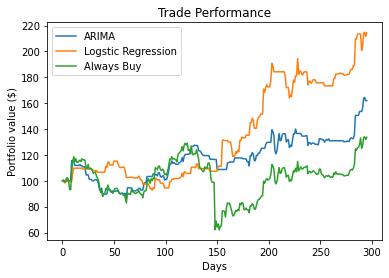

In [ ]:

plt.plot(range(0, len(base_portfolio_value_history)), base_portfolio_value_history, label='ARIMA')    
plt.plot(range(0, len(portfolio_value_history)), portfolio_value_history, label='Logstic Regression')
plt.plot(range(0, len(always_buy_portfolio_value_history)), always_buy_portfolio_value_history, label='Always Buy')

plt.xlabel('Days')
plt.ylabel('Portfolio value ($)')
plt.title("Trade Performance")
plt.legend(["ARIMA", "Logstic Regression", "Always Buy"])
plt.show()